In [1]:
from util.gen_utils import *
from util.ml_utils import *
from util.plot_utils import *

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load fitted model and asso attributes
* Fitted model
* Features included in model [in order]
* Train data mask

In [2]:
best_fit = {'model' : read_pkl('out/ml/fitted_model.pkl'),
            'features' : pd.MultiIndex.from_frame(pd.read_csv('out/ml/fitted_model_features.csv')),
            'stable_genes' : pd.MultiIndex.from_frame(pd.read_csv('out/ml/stable_genes.csv')),
            'threshold' : read_pkl('out/ml/selected_tshld.pkl')
           }

all_masks = read_pkl('out/ml/train_data_masks.pkl')
train_mask = np.logical_or(all_masks.masks['is_training_and_is_collected_pre17wks'], all_masks.masks['not_is_training_and_is_collected_pre17wks'])
train_late_mask = np.logical_and(all_masks.masks['is_training_and_not_is_collected_pre17wks'], all_masks.masks['is_training_and_not_is_pp'])

# Load data
* Training data
* Validation RT-qPCR data
* Del Vecchio et al independent data
* Munchel et al S2/S3 independent data

In [3]:
ml_data_kwargs = {'to_norm_to_stable_genes' : True, 
                  'stable_genes' : best_fit['stable_genes'],
                  'to_center' : True, 
                  'to_scale' : True,
                  'features' : best_fit['features'],
                  'only_gene_name' : False
                 }

In [4]:
path_prefix = "../../data/rnaseq_stanford_all/discovery/"
train_all = rnaseq_and_meta_data(path_prefix + "sample_meta_postQC.csv", 
                                 path_prefix + "logCPM_postQC_RemovedBatch.csv",
                                 path_prefix + "TMM_postQC.csv",
                                 is_logCPM_path_R = True,
                                 counts_index_cols = [0],
                                 mygene_db = mygene.MyGeneInfo()
                                ) #Annotation info to intersect with ML gene set



querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7160...done.
Finished.
16 input query terms found no hit:
	['ENSG00000116957', 'ENSG00000130723', 'ENSG00000133808', 'ENSG00000150076', 'ENSG00000155640', 'ENS
querying 1-16...done.
Finished.
8 input query terms found no hit:
	['AL356053.1', 'none', 'AC098614.2', 'CTB-133G6.1', 'none', 'RP11-367G6.3', 'none', 'none']


In [5]:
train_ml_data = ML_data(rnaseq_meta = train_all.filter_samples(train_mask, inplace = False), 
                        y_col = 'case', 
                        group_col = 'subject', 
                        **ml_data_kwargs)

train_pre14_week = ML_data(rnaseq_meta = train_all.filter_samples(np.logical_and(train_mask, train_all.meta.ga_at_collection < 14), inplace = False), 
                        y_col = 'case', 
                        group_col = 'subject', 
                        **ml_data_kwargs)

In [6]:
#Combine both datasets used in training for reporting
val_path_prefix = "../../data/rnaseq_stanford_all/val/"
val_data = rnaseq_and_meta_data(val_path_prefix + "sample_meta_postQC.csv", 
                                         val_path_prefix + "htseq_postQC.csv", 
                                         val_path_prefix + "TMM_postQC.csv"
                                        )

val_data.filter_samples((val_data.meta.ga_at_collection <= 16))

In [7]:
val_ml_data = ML_data(rnaseq_meta = val_data,
                      y_col = 'case',
                      group_col = 'subject',
                      **ml_data_kwargs,
                      fitted_scaler = train_ml_data.fitted_scaler
                     )

val_pre14_week = ML_data(rnaseq_meta = val_data.filter_samples(val_data.meta.ga_at_collection < 14, inplace = False),
                      y_col = 'case',
                      group_col = 'subject',
                      **ml_data_kwargs,
                      fitted_scaler = train_ml_data.fitted_scaler
                     )

In [8]:
delvecchio_all = rnaseq_and_meta_data("../../data/delvecchio_data/sample_meta_w_ga_col.csv", 
                                 "../../data/delvecchio_data/htseq_merged.csv", 
                                 "../../data/delvecchio_data/TMM.csv",  mL_plasma = 0.2)

delvecchio_all.filter_samples(delvecchio_all.meta.term == 1)
gest_ht_id = ['SRR12214586', 'SRR12214596', 'SRR12214601']
delvecchio_all.filter_samples(~delvecchio_all.meta.index.isin(gest_ht_id))

for i in np.arange(2):
    #ML data should only contains samples <= 16 weeks which per Del Vecchio et al are T1 samples
    filter_mask = (delvecchio_all.meta.term == 1) if i == 0 else (delvecchio_all.meta.ga_at_collection < 14)

    dv_use = delvecchio_all.filter_samples(filter_mask, inplace = False)
    only_pe_v_NT = dv_use.meta.loc[dv_use.meta.complication_during_pregnancy.isin(['No Complications', 'Preeclampsia/gestational hypertension'])].index

    if i == 0:
        delvecchio_ml_data = ML_data(dv_use, y_col = 'case', 
                                     **ml_data_kwargs,
                                    fitted_scaler = train_ml_data.fitted_scaler
                                    )
        #Only PE vs NT
        delvecchio_ml_data_only_PEvNT = delvecchio_ml_data.filter_samples(only_pe_v_NT)

    else:
        delvecchio_pre14_wks = ML_data(dv_use, y_col = 'case', 
                                     **ml_data_kwargs,
                                    fitted_scaler = train_ml_data.fitted_scaler
                                    )
        #Only PE vs NT
        delvecchio_pre14_wks_only_PEvNT = delvecchio_pre14_wks.filter_samples(only_pe_v_NT)

In [9]:
gapps = rnaseq_and_meta_data("../../data/gapps/sample_meta_postQC.csv",
                             "../../data/gapps/htseq_postQC.csv", 
                             "../../data/gapps/TMM_postQC.csv",  
                             mL_plasma = 1.0
                            )


gapps_ml_data = ML_data(gapps, y_col = 'case',
                        **ml_data_kwargs,
                        fitted_scaler = train_ml_data.fitted_scaler
                       )

gapps_pre14wks = ML_data(gapps.filter_samples(gapps.meta.ga_at_collection < 14, inplace = False),
                        y_col = 'case',
                        **ml_data_kwargs,
                        fitted_scaler = train_ml_data.fitted_scaler
                       )

In [10]:
pre17wk_samples = {'Discovery' : train_ml_data,
                   'Validation 1' : val_ml_data,
                   'Validation 2' : gapps_ml_data,
                   'Del Vecchio' : delvecchio_ml_data, 
                  }

pre17wk_samples_only_PE_NT = {'Discovery' : train_pre14_week,
                              'Validation 1' : val_ml_data,
                              'Validation 2' : gapps_ml_data,
                              'Del Vecchio' : delvecchio_ml_data_only_PEvNT, 
                             }

pre14wk_samples = {'Discovery' : train_ml_data,
                   'Validation 1' : val_pre14_week,
                   'Validation 2' : gapps_pre14wks,
                   'Del Vecchio' : delvecchio_pre14_wks,
                   'Del Vecchio [Only NT vs PE]' : delvecchio_pre14_wks_only_PEvNT
                  }

In [11]:
get_min_max_ga_collection(pre17wk_samples, {'Discovery' : train_all, 'Validation 1' : val_data, 'Del Vecchio' : delvecchio_all, 'Validation 2' : gapps}, coll_name = 'Pre 17 wks')

Pre 17 wks: Min = 5, Max = 17


# Get model performance
* PPV, NPV, Sensitivity, Specificity and 95% CI bounds

In [12]:
#Pre 17 weeks
print('Samples collected at or prior to 16 weeks gestation:')
pre17wk_stats = {dataset_name : get_model_stats(dataset_name, ml_obj, best_fit['model'], threshold = best_fit['threshold']) for dataset_name, ml_obj in {**pre17wk_samples, **{'Del Vecchio et al 2020 [NT vs PE only]' : delvecchio_ml_data_only_PEvNT}}.items()}

Samples collected at or prior to 16 weeks gestation:
Discovery: Sensitivity = 100% [92-100%], Specificity = 85% [77-91%], PPV = 73% [59-84%], NPV = 100% [96-100%], AUC = 0.99 [0.993-0.994]
Validation 1: Sensitivity = 75% [46-92%], Specificity = 56% [43-70%], PPV = 28% [15-46%], NPV = 91% [77-97%], AUC = 0.71 [0.705-0.716]
Validation 2: Sensitivity = 56% [42-72%], Specificity = 69% [59-78%], PPV = 46% [32-59%], NPV = 78% [68-86%], AUC = 0.72 [0.715-0.721]
Del Vecchio: Sensitivity = 60% [26-87%], Specificity = 100% [89-100%], PPV = 100% [56-100%], NPV = 89% [74-97%], AUC = 0.74 [0.734-0.748]
Del Vecchio et al 2020 [NT vs PE only]: Sensitivity = 60% [26-87%], Specificity = 100% [79-100%], PPV = 100% [56-100%], NPV = 80% [55-94%], AUC = 0.80 [0.793-0.807]


# Visualize ROC curve
* Using samples collected at or before 16 weeks gestation (Discovery dataset, Del Vecchio et al 2020)
* Using samples collected at diagnosis (Munchel et al 2020)

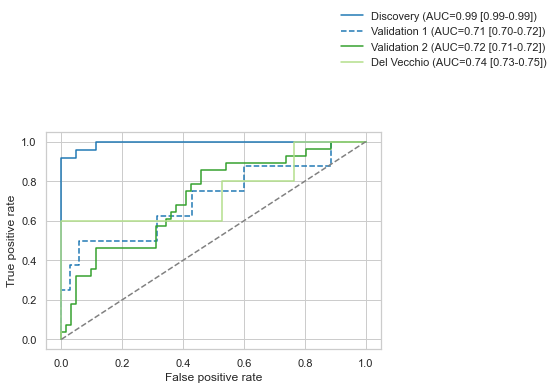

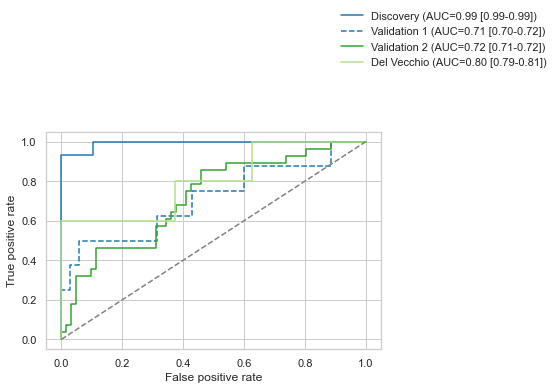

In [13]:
roc_aucs_pr_pre17wk_samples = {key : get_auc_roc_CI(best_fit['model'], data_obj) for key, data_obj in pre17wk_samples.items()}
roc_aucs_pre17wk_onlyPE_NT_samples = {key : get_auc_roc_CI(best_fit['model'], data_obj) for key, data_obj in pre17wk_samples_only_PE_NT.items()}

plot_roc_curves(roc_aucs_pr_pre17wk_samples, linestyles = ['solid', 'dashed', 'solid', 'solid'], palette = discovery_test2_palette, save_path = 'out/ml/viz/roc_curve_pre17wks.pdf')
plot_roc_curves(roc_aucs_pre17wk_onlyPE_NT_samples, linestyles = ['solid', 'dashed', 'solid', 'solid'], palette = discovery_test2_palette, save_path = 'out/ml/viz/roc_curve_pre17wks_ONLY_PEvNT.pdf')

# Visualize probability(PE) outputted from model

In [14]:
probPE_pre17wk_samples, X_pre17wk_samples = make_probPE_and_gene_matrix(pre17wk_samples, best_fit['model'], threshold = best_fit['threshold'])

/Users/miramou/miniconda3/envs/gen_comp/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


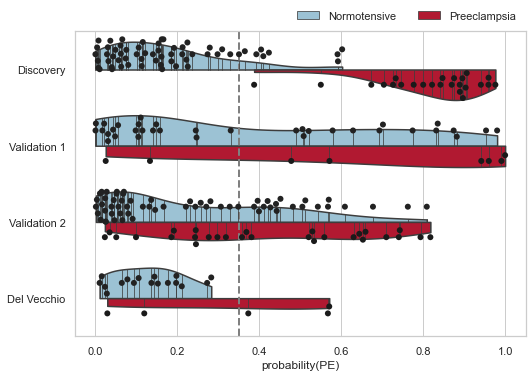

In [15]:
fig, ax = plot_violin_and_swarmplot(probPE_pre17wk_samples, x_name = 'prob_PE', y_name = 'dataset', hue_name = 'case', orient = 'h', violinplot_palette = cntrl_pe_palette,
                                    x_label = 'probability(PE)', y_label = '', split = True, figsize = (7.5, 5), 
                                    include_vline = True, line_pos = best_fit['threshold'], line_start = -3, line_end = 4) #p(PE) >= threshold --> classified as at risk

fig.tight_layout()
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ['Normotensive', 'Preeclampsia'], ncol=2, frameon=0, bbox_to_anchor=(1.0, 1.1))
save_figure_pdf(fig, 'out/ml/viz/probPE_pre17wks.pdf')

# What trends (if any) exist in mistakes?

In [16]:
cols_to_use = {'ga_at_collection' : 'Gestational age at collection (weeks)'}

#Drop DV since don't have ind meta
prob_w_meta = probPE_pre17wk_samples.join(pd.concat((train_all.meta.loc[:, cols_to_use.keys()], 
                                                     val_data.meta.loc[:, cols_to_use.keys()],
                                                     gapps.meta.loc[:, cols_to_use.keys()],
                                                    delvecchio_all.meta.loc[:, cols_to_use.keys()])), how = 'inner')

prob_w_meta['dataset_case'] = prob_w_meta['dataset'] + prob_w_meta['case'].astype(str)
prob_w_meta['dataset_case'] = pd.Categorical(prob_w_meta['dataset_case'], ordered = True, categories = ['Discovery0', 'Discovery1',
                                                                                                        'Validation 10', 'Validation 11',
                                                                                                        'Validation 20', 'Validation 21',
                                                                                                       'Del Vecchio0', 'Del Vecchio1'])

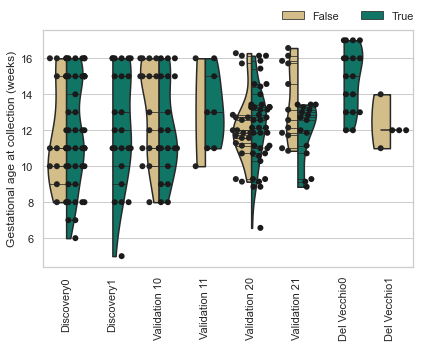

In [17]:
for factor, y_label in cols_to_use.items():
    to_use = prob_w_meta.loc[prob_w_meta.case == 1] if factor in ['pe_feature', 'pe_onset_ga_wk'] else prob_w_meta
    fig, ax = plot_violin_and_swarmplot(df = to_use.dropna(subset = [factor]), x_name = 'dataset_case', y_name = factor, hue_name = 'correctly_predicted', orient = 'v', violinplot_palette = reversed(outlier_palette),
                                           y_label = y_label, x_label = '', split = True, inner = 'sticks', figsize = (6, 5))

    l = ax.get_xticklabels()
    ax.set_xticklabels(l, rotation = 90)
    
    h,l = ax.get_legend_handles_labels()
    plt.legend(h[0:2], l[0:2], ncol = 2, frameon=0, bbox_to_anchor=(1.03, 1.12))
    #ax.legend().remove()
    fig.tight_layout()
    
save_figure_pdf(fig, 'out/ml/viz/trends_in_errors.pdf')

In [18]:
prob_w_meta.groupby(['dataset_case', 'correctly_predicted']).agg({'ga_at_collection' : ['mean', 'median', 'std']})

ga_at_collection                     
                                              mean     median       std
dataset_case  correctly_predicted                                      
Discovery0    False                      11.777778  11.000000  3.073181
              True                       11.980769  11.500000  2.960461
Discovery1    False                            NaN        NaN       NaN
              True                       12.250000  12.000000  3.220181
Validation 10 False                      13.266667  15.000000  2.711527
              True                       12.000000  11.000000  2.675424
Validation 11 False                      13.000000  13.000000  4.242641
              True                       13.166667  13.000000  2.041241
Validation 20 False                      12.270661  11.857142  1.956932
              True                       12.268687  12.571428  2.115919
Validation 21 False                      13.511904  12.857142  2.131536
              True                       11.928571  12.642857  1.620448
Del Vecchio0  False                            NaN        NaN       NaN
              True                       14.882353  15.000000  1.798692
Del Vecchio1  False                      12.500000  12.500000  2.121320
              True                       12.000000  12.000000  0.000000

In [19]:
print('Samples collected at or prior to 14 weeks gestation:')
pre14wk_stats = {dataset_name : get_model_stats(dataset_name, ml_obj, best_fit['model'], threshold = best_fit['threshold']) for dataset_name, ml_obj in pre14wk_samples.items()}

Samples collected at or prior to 14 weeks gestation:
Discovery: Sensitivity = 100% [92-100%], Specificity = 85% [77-91%], PPV = 73% [59-84%], NPV = 100% [96-100%], AUC = 0.99 [0.993-0.994]
Validation 1: Sensitivity = 80% [44-96%], Specificity = 62% [44-77%], PPV = 33% [15-56%], NPV = 93% [75-99%], AUC = 0.72 [0.717-0.731]
Validation 2: Sensitivity = 65% [48-80%], Specificity = 68% [56-78%], PPV = 48% [34-63%], NPV = 81% [70-89%], AUC = 0.73 [0.728-0.735]
Del Vecchio: Sensitivity = 75% [35-95%], Specificity = 100% [69-100%], PPV = 100% [56-100%], NPV = 83% [51-97%], AUC = 0.90 [0.894-0.906]
Del Vecchio [Only NT vs PE]: Sensitivity = 75% [35-95%], Specificity = 100% [64-100%], PPV = 100% [56-100%], NPV = 80% [44-96%], AUC = 0.94 [0.933-0.942]


# Visualize model features
* Look at distribution across pre17_wks datasets for genes selected

In [20]:
X_pre17wk_samples_to_plot = X_pre17wk_samples.reset_index().melt(id_vars=['index', 'dataset', 'case'], var_name = 'gene_name_num', value_name = 'zc_logCPM').set_index('index')

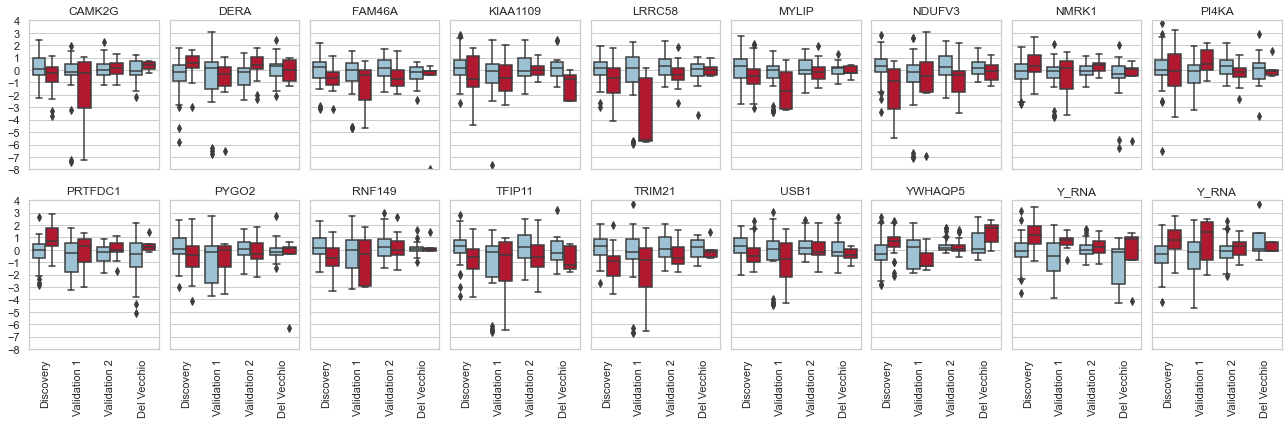

In [21]:
n_genes = len(best_fit['features'])
n_rows = 2
n_cols = np.ceil(n_genes / n_rows).astype(int)

fig, ax = plt.subplots(n_rows, n_cols, sharex = True, sharey = True, figsize = (18, 6))
ax_i, ax_j = (0,0)

for gene_name, X_data in X_pre17wk_samples_to_plot.groupby(['gene_name_num']): 
    sns.boxplot('dataset', 'zc_logCPM', hue = 'case', data = X_data, palette = cntrl_pe_palette, ax = ax[ax_i, ax_j])
    
    ax[ax_i, ax_j].tick_params(axis='x', rotation = 90)
    ax[ax_i, ax_j].set_ylabel('')
    ax[ax_i, ax_j].set_xlabel('')
    ax[ax_i, ax_j].set_title(gene_name[0])
    ax[ax_i, ax_j].get_legend().remove()
    ax[ax_i, ax_j].set_ylim([-8,4])
    ax[ax_i, ax_j].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    ax_j += 1
    
    if ax_j == n_cols:
        ax_i += 1
        ax_j = 0

fig.tight_layout()

save_figure_pdf(fig, 'out/ml/viz/genes_used_in_model.pdf')

In [22]:
#Calculate whether trends observed per gene meet significance

#To determine one-sided test direction
logFC_pre17_sig = logFC_data_by_group(best_fit['features'], {True : 'Pre 17 weeks'}, group_col = 'pre17_weeks')
logFC_pre17_sig.get_logFC_and_CI_by_group(train_all.rnaseq.logCPM.loc[best_fit['features'], :], 
                                          train_all.meta.join(train_mask.rename('pre17_weeks')))

Now calculating logFC for Pre 17 weeks
Now estimating logFC confidence interval for Pre 17 weeks
1000 resampling iterations completed
2000 resampling iterations completed
Identifying when during gestation we observe changes


In [23]:
n_ds = len(X_pre17wk_samples_to_plot.dataset.unique())
unadj_pvals = {ds : [] for ds in X_pre17wk_samples_to_plot.dataset.unique()}
adj_pvals_dict = {ds : [] for ds in X_pre17wk_samples_to_plot.dataset.unique()}
to_reject_dict = {ds : [] for ds in X_pre17wk_samples_to_plot.dataset.unique()}

genes = []
for key, X_data in X_pre17wk_samples_to_plot.groupby(['gene_name_num', 'dataset']):
    gene, dataset = key
        
    #Want to test that validation follows same trend across case vs control as discovery so one-sided
    alternative = 'less' if (np.sign(logFC_pre17_sig.logFC.loc[gene]) == -1).iloc[0] else 'greater'
    unadj_pval, _ = test_and_adj([(1, 0)], X_data, 'case', 'zc_logCPM', alternative = alternative, use_ttest = False)
    unadj_pvals[dataset].append(unadj_pval[(1, 0)])
    
    if len(genes) == 0 or genes[-1] != gene:
        genes.append(gene)
    
    to_reject_dict[dataset], adj_pvals_dict[dataset], _, _ = multitest_corr(unadj_pvals[dataset], method = 'fdr_bh', alpha = 0.05)

to_reject = pd.DataFrame(to_reject_dict, index = pd.MultiIndex.from_tuples(genes, names = ['gene_name', 'gene_num'])) 
adj_pvals = pd.DataFrame(adj_pvals_dict, index = pd.MultiIndex.from_tuples(genes, names = ['gene_name', 'gene_num'])) 

adj_pvals_full = adj_pvals.merge(to_reject, left_index = True, right_index = True, suffixes = ('', '_is_sig'))
adj_pvals_full

,,Discovery,Validation 1,Validation 2,Del Vecchio,Discovery_is_sig,Validation 1_is_sig,Validation 2_is_sig,Del Vecchio_is_sig
gene_name,gene_num,,,,,,,,
CAMK2G,ENSG00000148660,0.002138,0.478598,0.645474,0.708299,True,False,False,False
DERA,ENSG00000023697,0.001816,0.726053,0.000802,0.690746,True,False,True,False
FAM46A,ENSG00000112773,0.001846,0.465656,0.007653,0.690746,True,False,True,False
KIAA1109,ENSG00000138688,0.037135,0.478598,0.524873,0.309606,True,False,False,False
LRRC58,ENSG00000163428,0.006990,0.146383,0.005696,0.690746,True,False,True,False
MYLIP,ENSG00000007944,0.011327,0.275353,0.063784,0.690746,True,False,False,False
NDUFV3,ENSG00000160194,0.000103,0.632089,0.007668,0.682471,True,False,True,False
NMRK1,ENSG00000106733,0.008337,0.478598,0.005696,0.690746,True,False,True,False
PI4KA,ENSG00000241973,0.221727,0.981026,0.010196,0.690746,False,False,True,False


In [28]:
adj_pvals_full.iloc[:, :4].round(4).to_csv('out/ml/ML_exact_pvals.csv')

# Save model features + annotations

In [24]:
odds_ratio = np.exp(best_fit['model'].coef_[0, :]).round(2)
full_ML_heatmap_table = pd.DataFrame(data = {'Odds ratio' : odds_ratio}, index = best_fit['features'].copy()) 

#Drop all columns except merged one, add annotation, and save
full_ML_heatmap_table = full_ML_heatmap_table.join(train_all.rnaseq.anno)
full_ML_heatmap_table.index.names = ['Gene', "ENSEMBL"]
full_ML_heatmap_table.rename(columns = {'name' : 'Name', 'gene_type' : 'Type', 'summary' : 'Summary', 
                                         'GO_BP' : 'Biological process [GO]', 'GO_MF' : 'Molecular function [GO]'}, inplace = True)

full_ML_heatmap_table.iloc[:, [1,0,3,4,5]].to_csv('out/ml/ML_PEspecific_genes_noColFormatting.csv')
full_ML_heatmap_table

,,Odds ratio,Name,Type,Summary,Biological process [GO],Molecular function [GO]
Gene,ENSEMBL,,,,,,
TRIM21,ENSG00000132109,0.88,tripartite motif containing 21,protein_coding,This gene encodes a member of the tripartite m...,"regulation of gene expression, positive regula...","protein kinase binding, ubiquitin-protein tran..."
Y_RNA,ENSG00000201412,1.85,Y RNA,misc_RNA,NaN,NaN,NaN
LRRC58,ENSG00000163428,0.79,leucine rich repeat containing 58,protein_coding,NaN,NaN,NaN
NDUFV3,ENSG00000160194,0.66,NADH:ubiquinone oxidoreductase subunit V3,protein_coding,The protein encoded by this gene is one of at ...,"mitochondrial electron transport, NADH to ubiq...","RNA binding, NADH dehydrogenase (ubiquinone) a..."
KIAA1109,ENSG00000138688,0.89,KIAA1109,protein_coding,This gene is located on the long arm of chromo...,"endocytic recycling, endosomal transport, regu...",protein binding
MYLIP,ENSG00000007944,0.94,myosin regulatory light chain interacting protein,protein_coding,"The ERM protein family members ezrin, radixin,...","protein ubiquitination, negative regulation of...","ubiquitin-protein transferase activity, protei..."
USB1,ENSG00000103005,0.85,U6 snRNA biogenesis phosphodiesterase 1,protein_coding,This gene encodes a protein with several conse...,"snRNA 3'-end processing, U6 snRNA 3'-end proce...","3'-5'-exoribonuclease activity, protein bindin..."
RNF149,ENSG00000163162,0.82,ring finger protein 149,protein_coding,NaN,"protein ubiquitination, ubiquitin-dependent pr...","ubiquitin protein ligase activity, metal ion b..."
TFIP11,ENSG00000100109,0.90,tuftelin interacting protein 11,protein_coding,This gene encodes a protein component of the s...,"mRNA splicing, via spliceosome, protection fro...","protein binding, nucleic acid binding"
